# IV.H - Tampering Telltales - Occlusion xAI



### Imports & Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import os, sys

from itertools import product
import pyproj


from dataLoaderXAI import DataLoaderXAI, preprocess_time


from tf.keras.models import Model, load_model
from tf.keras.layers import Input
from tf.keras.losses import mean_squared_error



batchSize = 1
pathToModel = "../IV.B_ablation_study/denseNet/gr_oh_loc_time_TA/weights.30-0.57407.hdf5"
gpuNumber = 4


## GPU selection
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[gpuNumber], 'GPU')
tf.config.experimental.set_memory_growth(gpus[gpuNumber], True)



#######################
##    Custom MSE     ##
#######################
# We will compute the MSE only for the consistent inputs
def transient_mse(y_true, y_pred):
    return tf.sum(mean_squared_error(y_true[0::2,:], y_pred[0::2,:]), axis=-1)



#######################
## Deprocess time
#######################
def deprocess_time(time):
    month, hour = time
    month = (11.0 / 2.0) * (month + 1) + 1
    hour = (23.0 / 2.0) * (hour + 1)
    return (int(round(month)), int(round(hour)))

def deprocess_loc(loc):
    _earth_radius = 6378137.0
    x,y,z = loc
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    lon, lat, alt = pyproj.transform(ecef, lla, x * _earth_radius, y*_earth_radius, z*_earth_radius, radians=False)
    return (lat, lon, alt)

Using TensorFlow backend.


### Load architecture

In [ ]:
baseModel = load_model(pathToModel, custom_objects={"transient_mse": transient_mse})
print(baseModel.summary())

groundBranchModel = Model(baseModel.get_layer("groundInput").input, 
                          baseModel.get_layer("batch_normalization_2").output)
aerialBranchModel = Model(baseModel.get_layer("aerialInput").input, 
                          baseModel.get_layer("batch_normalization_4").output)
locBranchModel = Model(baseModel.get_layer("locationInput").input, 
                       baseModel.get_layer("batch_normalization_7").output)
timeBranchModel =  Model(baseModel.get_layer("timeInput").input, 
                         baseModel.get_layer("batch_normalization_10").output)


combinedFeaturesInput = Input(shape=(512,), name='concatenate_1_proxy')
combinedFeatures = baseModel.get_layer("consist_fc1")(combinedFeaturesInput)
combinedFeatures = baseModel.get_layer("batch_normalization_11")(combinedFeatures)
combinedFeatures = baseModel.get_layer("consist_fc2")(combinedFeatures)
combinedFeatures = baseModel.get_layer("batch_normalization_12")(combinedFeatures)
combinedFeatures = baseModel.get_layer("consist_fc3")(combinedFeatures)
combineModel = Model(combinedFeaturesInput, combinedFeatures)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




--------------
--------------
--------------
--------------


### Predicting the consistency probability for all hours and months

The `skipCount` variable allows us to control which image would be selected (without needing to adapt much of the dataLoader)

In [ ]:
dl = DataLoader("test", 
                includeLocation = True, 
                includeSatellite = True, 
                outputTransientAttributes = True)

skipCount = 10

for batch, pathBatch, _ in dl.loadTestDataInBatchesWithPath(batchSize):
    if skipCount >= 1:
        skipCount-=1
        continue
    
    grImg, aeImg, locInfo, timeInfo = [batch[i][0:1] for i in range(len(batch))]
    
    grFeatures = groundBranchModel.predict_on_batch(grImg)
    aeFeatures = aerialBranchModel.predict_on_batch(aeImg)
    locFeatures = locBranchModel.predict_on_batch(locInfo)
    
    locInfo = deprocess_loc(locInfo[0])
    realTimeInfo = deprocess_time(timeInfo[0]) 
    
    timeList, predList = [], []
    for month, hour in product(range(1,13), range(24)):
        timeFeatures = timeBranchModel.predict_on_batch(preprocess_time((month, hour)).reshape(1,-1))
        concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, timeFeatures))
        pred = consistModel.predict_on_batch(concatFV)
        consistentProb = pred[0][0]
        
        timeList += [(month, hour)]
        predList += [consistentProb]
    break
    

sortedTimeList = [(y,x) for y,x in sorted(zip(predList,timeList), 
                                              key=lambda pair: pair[0], reverse=True)]
sortedProbs = [l[0] for l in sortedTimeList]
sortedTimes = [l[1] for l in sortedTimeList]

Given the location (`locInfo`), we shifted the heatmap based on the timeZone to present it as local time rather than UCT. 

In [ ]:
print("Correct time: ", realTimeInfo)
print("Location coordinates: ", locInfo)

timeZone = +1

('Correct time: ', (12, 1))
('Location coordinates: ', (50.1065184167, 8.678006826950002, 1.862645149230957e-09))


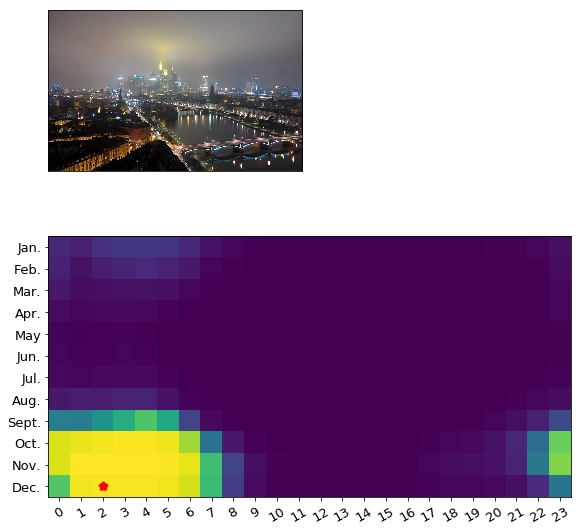

In [8]:
adjustedHeatMapMatrix = np.zeros((12, 24))
for i in range(len(predList)):
    month, hour = timeList[i]
    adjustedHeatMapMatrix[month-1,((hour + timeZone)%24)] = predList[i]
    
    
fig=plt.figure(figsize=(8,8))
columns = 2
rows = 2

fig.add_subplot(rows, columns, 1)
fig.tight_layout()



deprocessed_grImg = mpimg.imread(pathBatch[0])
plt.xticks([])
plt.yticks([])
plt.imshow(deprocessed_grImg)

fig.add_subplot(rows, 1, 2)
fig.tight_layout()

# plt.colorbar()
plt.xticks(range(0,24), range(0,24), rotation=30, size=13)
plt.yticks(range(0,13), 
           ["Jan.", "Feb.", "Mar.", "Apr.", "May", "Jun.", "Jul.", "Aug.", "Sept.", "Oct.", "Nov.", "Dec."],
           size=13)
plt.scatter((realTimeInfo[1]+timeZone)%24, realTimeInfo[0]-1, lw=4, c='r', marker="*")
plt.imshow(adjustedHeatMapMatrix, cmap='viridis')

plt.show()

### Generate occluded images and forward to the network

In [19]:
sizeArray = [(50,50), (100,100), (50,100), (100, 50)]

fillValue = 0.0
occlusion_scores = np.zeros((grImg.shape[1], grImg.shape[2]))
t_occlusion_scores = np.zeros((grImg.shape[1], grImg.shape[2]))
visitedPixels = np.zeros((grImg.shape[1], grImg.shape[2]))

#Select time
evaluatedTime = (7, 1)
timeInput = preprocess_time(evaluatedTime).reshape(1,-1)

#Compute time features
timeFeatures = timeBranchModel.predict_on_batch(timeInput)
concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, timeFeatures))
pred = consistModel.predict_on_batch(concatFV)
originalConsistentProb = pred[0][0]
originalTamperedProb = pred[0][1]

print("Original consistency prob: ", originalConsistentProb)
print("Original tampered prob: ", originalTamperedProb)

progress = 0
total = sum([(grImg.shape[1] - size[0]) * (grImg.shape[2] - size[1]) for size in sizeArray])
print(progress, " / ", total)
for size in sizeArray:
    occlusion_window = np.zeros((1, size[0], size[1], grImg.shape[3]))
    occlusion_window.fill(fillValue)

    for row in range(grImg.shape[1] - size[0]+1):
        for col in range(grImg.shape[2] - size[1]+1):
            occludedImg = np.array(grImg)

            occludedImg[0, row:(row+size[0]), col:(col+size[1]), :] = occlusion_window

            grFeatures = groundBranchModel.predict_on_batch(occludedImg)
            concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, timeFeatures))
            pred = consistModel.predict_on_batch(concatFV)
            consistentProb = pred[0][0]
            tamperedProb = pred[0][1]
            
            score_diff = max(originalConsistentProb - consistentProb, 0)
            occlusion_scores[row:(row+size[0]), col:(col+size[1])] += score_diff
            
            score_diff = max(originalTamperedProb - tamperedProb, 0)
            t_occlusion_scores[row:(row+size[0]), col:(col+size[1])] += score_diff
            
            visitedPixels[row:(row+size[0]), col:(col+size[1])] += 1
            
            progress+=1
            if progress%int(total/10) == 0:
                print(progress, " / ", total)

('Original consistency prob: ', 0.037136924)
('Original tampered prob: ', 0.96286315)
(0, ' / ', 88804)
(8880, ' / ', 88804)
(17760, ' / ', 88804)
(26640, ' / ', 88804)
(35520, ' / ', 88804)
(44400, ' / ', 88804)
(53280, ' / ', 88804)
(62160, ' / ', 88804)
(71040, ' / ', 88804)
(79920, ' / ', 88804)
(88800, ' / ', 88804)


(255, 0)


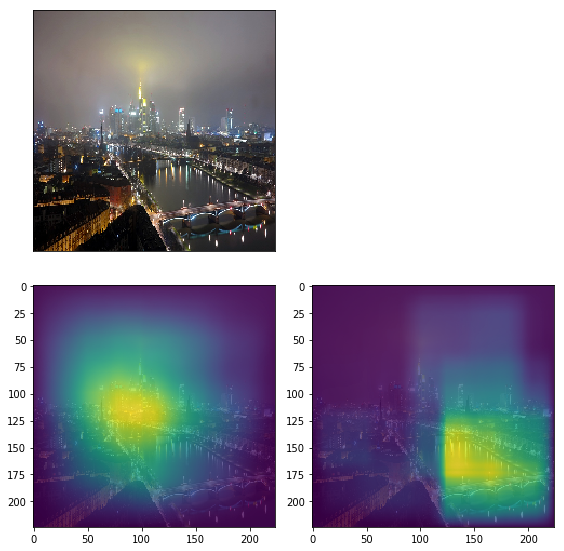

In [21]:
from PIL import Image

fig=plt.figure(figsize=(8,8))
columns = 2
rows = 2

fig.add_subplot(rows, columns, 1)
fig.tight_layout()


deprocessed_grImg = Image.open(pathBatch[0]) 
deprocessed_grImg = deprocessed_grImg.resize((224,224))


plt.xticks([])
plt.yticks([])
plt.imshow(deprocessed_grImg)


fig.add_subplot(rows, columns, 3)
fig.tight_layout()
occlusionMap = (occlusion_scores - np.min(occlusion_scores)) / (np.max(occlusion_scores) - np.min(occlusion_scores))
plt.imshow(deprocessed_grImg)
plt.imshow(255 * occlusionMap, alpha=0.8, cmap='viridis')

fig.add_subplot(rows, columns, 4)
fig.tight_layout()
occlusionMap = (t_occlusion_scores - np.min(t_occlusion_scores)) / (np.max(t_occlusion_scores) - np.min(t_occlusion_scores))
plt.imshow(deprocessed_grImg)
plt.imshow(255 * occlusionMap, alpha=0.8, cmap='viridis')

plt.show()